## Entrainement d'un modèle avec la méthode Knn

In [10]:
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt

### 1) Fonctions de Preprocessing des datasets

In [11]:
AVERAGE_SIZE_IMAGE = (127, 145)  # Thanks to the stats, we know that size of bbox will be (127, 145) -> Average size of labels 

def generate_empty_bbox(image_width, image_height):
    """ 
    Generate an empty box for images without label
    """
    # Generating random coords for the bbox
    x_min = random.randint(0, image_width - AVERAGE_SIZE_IMAGE[0])
    y_min = random.randint(0, image_height - AVERAGE_SIZE_IMAGE[1])
    
    # Compute complete coords of the bbox
    x_max = x_min + AVERAGE_SIZE_IMAGE[0]
    y_max = y_min + AVERAGE_SIZE_IMAGE[1]
    
    return (x_min, y_min, x_max, y_max)

def load_data(image_dir, label_dir):
    """ 
    Create a dict with all the usefull datas of the dataset
    datas = {
        "XXXX" (name of the file) : {
            "img" : image as an array,
            "labels" (data of the labels): {
                "X" index of the label (0,1,...,n) : {
                    "name" : name of the label,
                    "coord" : coord of the label like xmin, ymin, xmax, ymax,
                    "img" : crooped img of the label,
                }
            }
        }
    }
    """
    
    datas = {}

    for image_file in os.listdir(image_dir):
        # Computing name and files paths
        image_path = image_dir + '/' + image_file
        name = image_file.split('.')[0]
        label_path = label_dir + '/' + name + '.csv'
        
        # Import image as array
        image = np.array(Image.open(image_path))

        # Import labels as array 
        with open(label_path, 'r') as file:
            rows = file.readlines()

            label_data = {}
            if rows == ['\n']:  # Create a random empty label to balance model
                # Create random coords for empty label
                xmin, ymin, xmax, ymax = generate_empty_bbox(image.shape[1], image.shape[0])
    
                # Get the cropped image (as array) of the label
                cropped_image = np.array(Image.fromarray(image[ymin:ymax, xmin:xmax]).resize(AVERAGE_SIZE_IMAGE))
               
                label_data[0] = {
                        "name":"empty",
                        "coord": (xmin, ymin, xmax, ymax),
                        "img":cropped_image
                    }
            else:
                for i, row in enumerate(rows):  # One image can contain several labels
                    row = row.strip().split(",")

                    # Compute coords of the label
                    xmin, ymin, xmax, ymax = map(int, row[0:4])

                    # Get the label name
                    class_name = row[4]

                    # Get the cropped image (as array) of the label
                    cropped_image = np.array(Image.fromarray(image[ymin:ymax, xmin:xmax]).resize(AVERAGE_SIZE_IMAGE))
                    
                    # Adding to the json
                    label_data[i] = {
                        "name":class_name,
                        "coord": (xmin, ymin, xmax, ymax),
                        "img":cropped_image
                    }

        datas[name] = {
             "img" : image,
             "labels" : label_data,
        }
       
    return datas

# Dict to convert str class name to int
name_to_int = {
    "danger": 0,
    "interdiction": 1,
    "obligation": 2,
    "stop": 3,
    "ceder": 4,
    "frouge": 5,
    "forange": 6,
    "fvert": 7,
    "ff": 8,
    "empty": 9
}

### 2) Fonction de création des datasets

In [12]:
def create_xy(datas):
    # Creating arrays with all labels datas & classes
    X = []
    Y = []

    for name, data in datas.items():
        for row in data["labels"].values():
            image_as_array = np.array(row["img"]).flatten()
            X.append(image_as_array)
            Y.append(name_to_int[row["name"]])

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

### 3) Création des datasets

In [13]:
# Training dataset
datas_train = load_data("../../data/train/images", "../../data/train/labels")
X_train, Y_train = create_xy(datas=datas_train)

# Validation dataset
datas_val = load_data("../../data/val/images", "../../data/val/labels")
X_val, Y_val = create_xy(datas=datas_val)

### 4) Application de la méthode Knn

In [14]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5) # To change
clf.fit(X_train, Y_train)
y = clf.predict(X_val)

print(f"Taux d'erreur : {np.mean(y != Y_val)}")

Taux d'erreur : 0.31092436974789917


### 5) Test de la méthode Knn avec application des caractéristiques HOG

In [15]:
from skimage.feature import hog
from skimage.color import rgb2gray

def extract_hog(datas):
    # Creating X array with all HOG information of images
    X = []

    for name, data in datas.items():
        for row in data["labels"].values():
            image_as_array = np.array(hog(rgb2gray(row["img"]))).flatten()
            X.append(image_as_array)

    return np.array(X)


# Update training dataset
X_train_HOG = extract_hog(datas=datas_train)

# Update validation dataset
X_val_HOG = extract_hog(datas=datas_val)

In [16]:
clf = KNeighborsClassifier(n_neighbors=8)
clf.fit(X_train_HOG, Y_train)
y_HOG = clf.predict(X_val_HOG)

print(f"Taux d'erreur : {np.mean(y_HOG != Y_val)}")

Taux d'erreur : 0.17647058823529413


### 6) Test avec concaténation des informations de couleur

In [18]:
from skimage.color import rgb2hsv

def extract_color_features(datas):
    # Creating X array with all HOG information of images
    X = []

    for name, data in datas.items():
        for row in data["labels"].values():
            # Convertir l'image en espace colorimétrique HSV
            hsv_image = rgb2hsv(row["img"])

            # Calculer l'histogramme de couleur pour chaque canal
            hue_hist = np.histogram(hsv_image[:,:,0], bins=10, range=(0, 1), density=True)[0]
            saturation_hist = np.histogram(hsv_image[:,:,1], bins=10, range=(0, 1), density=True)[0]
            value_hist = np.histogram(hsv_image[:,:,2], bins=10, range=(0, 1), density=True)[0]

            # Concaténer les histogrammes de couleur
            color_features = np.concatenate((hue_hist, saturation_hist, value_hist))

            X.append(color_features)

    return np.array(X)


# Update training dataset
X_train_COLORS = extract_color_features(datas=datas_train)

# Update validation dataset
X_val_COLORS = extract_color_features(datas=datas_val)

In [34]:
X_train_combined = np.concatenate((X_train_HOG, X_train_COLORS), axis=1)
X_val_combined = np.concatenate((X_val_HOG, X_val_COLORS), axis=1)

clf = KNeighborsClassifier(n_neighbors=7) 
clf.fit(X_train_combined, Y_train)
y_combined = clf.predict(X_val_combined)

print(f"Taux d'erreur : {np.mean(y_combined != Y_val)}")

Taux d'erreur : 0.11764705882352941


### 7) Test des meilleurs paramètres à utiliser :

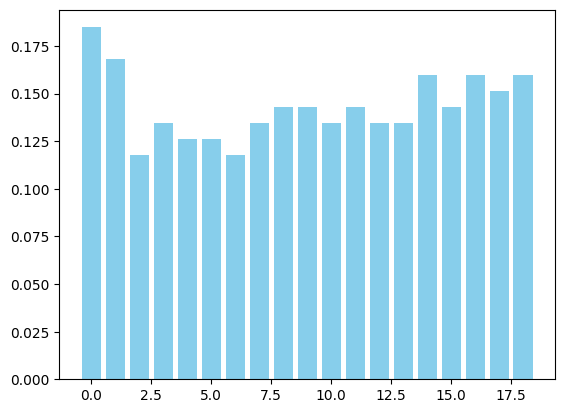

[0.18487394957983194, 0.16806722689075632, 0.11764705882352941, 0.13445378151260504, 0.12605042016806722, 0.12605042016806722, 0.11764705882352941, 0.13445378151260504, 0.14285714285714285, 0.14285714285714285, 0.13445378151260504, 0.14285714285714285, 0.13445378151260504, 0.13445378151260504, 0.15966386554621848, 0.14285714285714285, 0.15966386554621848, 0.15126050420168066, 0.15966386554621848]
Taux d'erreur minimum : 0.11764705882352941


In [38]:
tab = []

for i in range(1, 20, 1):
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train_combined, Y_train)
    y_combined = clf.predict(X_val_combined)
    tab.append(np.mean(y_combined != Y_val))

plt.bar(range(len(tab)), tab, color='skyblue')
plt.show()

print(tab)
print(f"Taux d'erreur minimum : {min(tab)}")